In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/Colab Notebooks/zDeep/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/zDeep


In [3]:
from workspace import *
import data

from tqdm.notebook import tqdm
import time

start = time.time()
test_seen = data.SDFDataset(data_dir, "test_seen", order, load_ram=False)
test_unseen = data.SDFDataset(data_dir, "test_unseen", order, load_ram=False)
seen_vecs = torch.load(os.path.join(model_dir, reconstructions_subdir, "seen.pth"), map_location=torch.device("cpu"))

end = time.time()
print("Data loaded in ", end-start, " seconds")

Data loaded in  6.988225698471069  seconds


In [17]:
from workspace import *
from utils import *
import data

from decoder import Decoder

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt

decoder = Decoder().to(device)

cp = torch.load(os.path.join(model_dir, model_params_subdir, "latest.pth"), map_location=device)

logs_cp = torch.load(os.path.join(model_dir, model_logs_subdir, "latest.pth"), map_location=device)
max_norm = logs_cp["lat_mag"][-1]

decoder.load_state_dict(cp["model_state_dict"])
decoder.eval()

loss_l1 = torch.nn.L1Loss(reduction="sum")

def enforce_max_norm(tensor, max_norm):
    with torch.no_grad():
        norm = tensor.norm(dim=-1, keepdim=True)
        desired = torch.clamp(norm, max=max_norm)
        tensor *= (desired / norm)

In [31]:
def reconstruct(sdf_data, init):
    latent = torch.ones(1, latent_size).normal_(0, sigma).to(device)
    latent.requires_grad = True
    g = torch.tensor([init])
    g = g.to(device)
    g.requires_grad = True
    optimizer = torch.optim.Adam([latent, g], lr=lrz)

    loss_l1 = torch.nn.L1Loss()

    num_recon_iters = 250
    for it in tqdm(range(num_recon_iters+1)):
        decoder.eval()
        sdf_data = sdf_data.reshape(-1, 3).to(device)

        sdf_gt = sdf_data[:, 2].unsqueeze(1)
        x = sdf_data[:, 0:2]

        optimizer.zero_grad()

        z = latent.expand(num_samp_per_scene, -1)

        pred_sdf = decoder(g, x, z)

        l1 = loss_l1(pred_sdf, sdf_gt)
        loss = l1 + code_reg_lambda * torch.mean(latent.pow(2))
        loss.backward()
        optimizer.step()

        enforce_max_norm(latent, max_norm)

    return latent.detach().cpu()

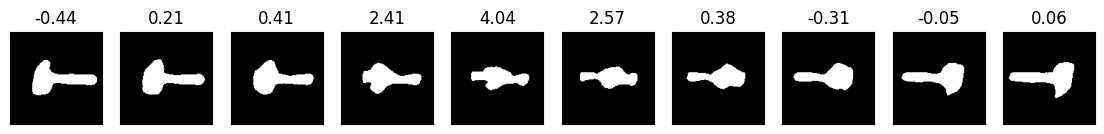

In [50]:
def interpolate(z1, z2):
    decoder.cpu()
    n = 8
    fig, axs = plt.subplots(1, n+2, figsize=(14, 4))

    zs = [z1]
    for i in range(1, n + 1):
        t = i / (n + 1)
        z = torch.lerp(z1, z2, t)
        zs.append(z)

    zs.append(z2)

    for ax, z in zip(axs.ravel(), zs):
        img = decode_latent(decoder, z)
        _, _, (l2, l3), _ = get_normalization_params(img)
        angle = np.degrees(np.arctan2(l3, l2)/2)

        ax.set_title(r"%.2f" % angle)
        ax.imshow(img, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# decoder.to(device)
# sdf, (l2, l3), _ = test_seen[2*34+1]
# init = np.arctan2(l3, l2)/2
# z1 = reconstruct(sdf, init)
# z2 = reconstruct(sdf, init+np.pi)
interpolate(z1, z2)

In [6]:
# from workspace import *
# from utils import *
# import data

# from decoder import Decoder

# import torch
# from tqdm import tqdm

# import matplotlib.pyplot as plt

# decoder = Decoder().to(device)


# cp = torch.load(os.path.join(model_dir, model_params_subdir, "latest.pth"), map_location=device)

# logs_cp = torch.load(os.path.join(model_dir, model_logs_subdir, "latest.pth"), map_location=device)
# max_norm = logs_cp["lat_mag"][-1]

# decoder.load_state_dict(cp["model_state_dict"])
# decoder.eval()

# loss_l1 = torch.nn.L1Loss(reduction="sum")

# ims = []
# its = []
# m2s = []
# gs  = []
# mag = []
# log = []

# # latent = torch.ones(1, latent_size).normal_(0, sigma).to(device)
# # latent.requires_grad = True
# # g = torch.rand(1).to(device)
# # optimizer = torch.optim.Adam([latent, g], lr=lrz)

# def enforce_max_norm(tensor, max_norm):
#     with torch.no_grad():
#         norm = tensor.norm(dim=-1, keepdim=True)
#         desired = torch.clamp(norm, max=max_norm)
#         tensor *= (desired / norm)

# def reconstruct(data, infer_pose=False, init=None):
#     latent = torch.ones(1, latent_size).normal_(0, sigma).to(device)
#     latent.requires_grad = True
#     if infer_pose:
#         # g = torch.tensor([0.0])
#         # g = torch.pi * (torch.rand(1) - 0.5)
#         g = torch.deg2rad(torch.tensor([init]))
#         g = g.to(device)
#         g.requires_grad = True
#         print("init g: ", torch.rad2deg(g))
#         optimizer = torch.optim.Adam([latent, g], lr=lrz)
#     else:
#         optimizer = torch.optim.Adam([latent], lr=lrz)

#     loss_l1 = torch.nn.L1Loss()

#     sdf_data, _, _ = data

#     img = samples_to_img(sdf_data.detach())
#     _, _, (lnd2, lnd3), _ = get_normalization_params(img)
#     m2 = np.degrees(np.arctan2(lnd3, lnd2)/2)
#     its.append(0)
#     ims.append(img)
#     mag.append(0.01)
#     gs.append(torch.rad2deg(g.detach().cpu()))


#     num_recon_iters = 1000
#     for it in tqdm(range(num_recon_iters+1)):
#         decoder.eval()
#         sdf_data, moments, _ = data
#         sdf_data = sdf_data.reshape(-1, 3).to(device)

#         sdf_gt = sdf_data[:, 2].unsqueeze(1)
#         x = sdf_data[:, 0:2]
#         if not infer_pose:
#             if order == 2:
#                 l2, l3 = moments[0], moments[1]
#                 g = (torch.atan2(l3, l2)/2).unsqueeze(0).to(device)
#             else:
#                 l3, l4 = moments[0], moments[1]
#                 g = torch.atan2(l4, l3).unsqueeze(0).to(device)

#         optimizer.zero_grad()

#         z = latent.expand(num_samp_per_scene, -1)

#         pred_sdf = decoder(g, x, z)

#         l1 = loss_l1(pred_sdf, sdf_gt)
#         loss = l1 + code_reg_lambda * torch.mean(latent.pow(2))
#         loss.backward()
#         optimizer.step()

#         enforce_max_norm(latent, max_norm)

#         log.append(loss.detach().cpu())
#         m = torch.norm(z[0].detach().cpu())
#         mag.append(m)

#         if it > 0 and it % int(num_recon_iters/10) == 0:
#             x = x.detach().cpu().numpy()
#             y = pred_sdf.detach().cpu().numpy()
#             im = np.append(x, y, axis=1)
#             img = samples_to_img(im)
#             _, _, (lnd2, lnd3), _ = get_normalization_params(img)
#             m2 = np.degrees(np.arctan2(lnd3, lnd2)/2)

#             ims.append(img)
#             m2s.append(m2)
#             its.append(it)
#             gs.append(torch.rad2deg(g.detach().cpu()))

#     fig, axs = plt.subplots(1, len(ims), figsize=(4*len(ims), 3))
#     for ax, im, it in zip(axs.ravel(), ims, its):
#         ax.imshow(im, cmap="gray")
#         ax.set_title(it, fontsize=32)
#         ax.set_xticks([])
#         ax.set_yticks([])
#     axs[0].set_title("gt", fontsize=32)

#     fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4))
#     ax1.plot(log)
#     ax3.plot(its[1:], m2s, label=r"$\theta_2$")
#     ax3.plot(its, gs, label=r"$\theta_i")
#     ax1.set_title("Loss")
#     ax3.set_title("Orientation")

#     _, _, (lnd2, lnd3), _ = get_normalization_params(ims[0])
#     t2 = np.degrees(np.arctan2(lnd3, lnd2)/2)
#     ax3.axhline(t2, linestyle="--", label="gt")
#     ax3.axhline(t2+180, linestyle="--", label=r"gt+$\pi$")
#     plt.legend()
#     plt.show()

#     # torch.save({f"loss{init}": log, f"m2s{init}": m2s, f"gs{init}": gs, f"its{init}": its}, path + "a")

#     print("infer g: ", torch.rad2deg(g.cpu()))
#     return latent.detach().cpu()

# if __name__ == "__main__":

#     # datum = test_unseen[4*20]
#     i = 0
#     datum = test_seen[i]
#     _, (lnd2, lnd3), _ = datum
#     t2 = np.degrees(np.arctan2(lnd3, lnd2)/2)
#     print("gt: ", t2)

#     z = seen_vecs(torch.tensor([i]))
#     z = reconstruct(datum, infer_pose=True, init=-30)
#     # z = reconstruct(datum, infer_pose=False)
#     im = decode_latent(decoder.cpu(), z)
#     _, _, (lnd2, lnd3), _ = get_normalization_params(im)
#     t2 = np.degrees(np.arctan2(lnd3, lnd2)/2)
#     print("z: ", t2)

#     plt.imshow(im)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title(r"$\theta$ = " + f"%.2f" % t2)


In [7]:
# from workspace import *
# from utils import *

# path = "test"


# logs = torch.load(path+"a", map_location=torch.device("cpu"))
# init = -30
# # init = 60
# loss = logs[f"loss{init}"]
# m2s = logs[f"m2s{init}"]
# gs = logs[f"gs{init}"]
# its = logs[f"its{init}"]

# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4))

# ax1.plot(loss, label="(a)")
# ax3.plot(its[1:], m2s, label=r"(a) $\theta_2$", c="cyan")
# ax3.plot(its, gs, label=r"(a) $\theta_i$")
# ax1.set_title("Loss")
# ax3.set_title("Orientation")

# # _, _, (lnd2, lnd3), _ = get_normalization_params(ims[0])
# # t2 = np.degrees(np.arctan2(lnd3, lnd2)/2)
# t2 = -48.5154
# ax3.axhline(t2, linestyle="--", label="gt")
# ax3.axhline(t2+180, linestyle="--", label=r"gt+$\pi$")

# init = 60
# logs = torch.load(path, map_location=torch.device("cpu"))
# loss = logs[f"loss{init}"]
# m2s = logs[f"m2s{init}"]
# gs = logs[f"gs{init}"]
# its = logs[f"its{init}"]

# ax1.plot(loss, label="(b)", c="r")
# ax3.plot(its[1:], m2s, label=r"(b) $\theta_2$")
# ax3.plot(its, gs, label=r"(b) $\theta_i$", c="r")
# ax1.set_title("Loss")
# ax3.set_title("Orientation")

# ax1.legend()
# ax3.legend()
# plt.show()